In [3]:

!pip install shap scikit-learn pandas numpy matplotlib seaborn joblib tqdm --quiet

In [4]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
DATA_PATH = list(uploaded.keys())[0]
df = pd.read_csv('/content/drugs_side_effects_drugs_com.csv')
print("✅ Dataset loaded:", df.shape)
df.head()

Saving drugs_side_effects_drugs_com.csv to drugs_side_effects_drugs_com (1).csv
✅ Dataset loaded: (2931, 17)


,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [5]:
import numpy as np

data = df.copy()
for col in ['side_effects', 'related_drugs']:
    if col in data.columns:
        data[col] = data[col].fillna('Unknown')

data['rating'] = pd.to_numeric(data.get('rating', 0), errors='coerce').fillna(0.0)
data['no_of_reviews'] = pd.to_numeric(data.get('no_of_reviews', 0), errors='coerce').fillna(0.0)

if 'activity' in data.columns:
    data['activity'] = data['activity'].astype(str).str.replace(r'\s+', '', regex=True).str.rstrip('%')
    data['activity'] = pd.to_numeric(data['activity'], errors='coerce').fillna(0.0) / 100.0
else:
    data['activity'] = 0.0

if 'alcohol' in data.columns:
    data['alcohol_flag'] = data['alcohol'].apply(lambda v: 1 if str(v).strip().upper() == 'X' else 0)
else:
    data['alcohol_flag'] = 0

def extract_side_effects_list(text):
    if pd.isna(text) or text == '' or text == 'Unknown':
        return []
    parts = [p.strip() for p in str(text).split(';') if p.strip()]
    if not parts:
        parts = [p.strip() for p in str(text).split(',') if p.strip()]
    return parts

data['side_effects_list'] = data['side_effects'].apply(extract_side_effects_list)
data['side_effect_count'] = data['side_effects_list'].apply(len)
data['side_effect_length'] = data['side_effects'].astype(str).apply(len)
data['contains_hives'] = data['side_effects'].str.lower().str.contains('hives', na=False).astype(int)
data['contains_difficult_breathing'] = data['side_effects'].str.lower().str.contains('difficult breathing|difficulty breathing', na=False).astype(int)
data['contains_itching'] = data['side_effects'].str.lower().str.contains('itching', na=False).astype(int)
data['drug_class_count'] = data.get('drug_classes', '').fillna('Unknown').apply(lambda x: len([c.strip() for c in str(x).split(',') if c.strip()]))

TOP_CONDITIONS = 15
if 'medical_condition' in data.columns:
    top_conditions = data['medical_condition'].value_counts().nlargest(TOP_CONDITIONS).index.tolist()
    data['medical_condition_top'] = data['medical_condition'].apply(lambda x: x if x in top_conditions else 'Other')
else:
    data['medical_condition_top'] = 'Unknown'

data['high_rating'] = (data['rating'] >= 8.0).astype(int)
print("Target distribution:\n", data['high_rating'].value_counts(normalize=True))

Target distribution:
 high_rating
0    0.805527
1    0.194473
Name: proportion, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

feature_numeric = ['activity','no_of_reviews','side_effect_count','side_effect_length',
                   'contains_hives','contains_difficult_breathing','contains_itching',
                   'drug_class_count','alcohol_flag']
X = data[['side_effects'] + feature_numeric + ['medical_condition_top']]
y = data['high_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

text_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2)))])
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'side_effects'),
    ('num', numeric_transformer, feature_numeric),
    ('cat', categorical_transformer, ['medical_condition_top']),
], remainder='drop', sparse_threshold=0)

model = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
pipeline = Pipeline([('preprocessor', preprocessor), ('clf', model)])

pipeline.fit(X_train, y_train)
print("✅ Model trained successfully.")


✅ Model trained successfully.


In [8]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("📈 Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

📈 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90       473
           1       0.77      0.09      0.16       114

    accuracy                           0.82       587
   macro avg       0.79      0.54      0.53       587
weighted avg       0.81      0.82      0.75       587

ROC-AUC: 0.8636827269018212


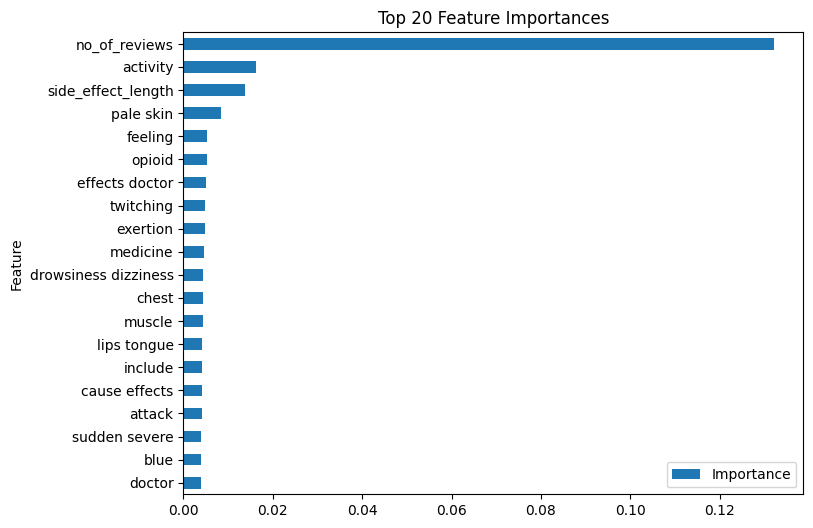

In [9]:
import matplotlib.pyplot as plt

tfidf = pipeline.named_steps['preprocessor'].named_transformers_['text'].named_steps['tfidf']
tfidf_names = tfidf.get_feature_names_out()
num_names = feature_numeric
cat_names = list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['medical_condition_top']))
feature_names = list(tfidf_names) + num_names + cat_names

importances = pipeline.named_steps['clf'].feature_importances_
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
fi_df.head(20).plot(kind='barh', x='Feature', figsize=(8,6), title="Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

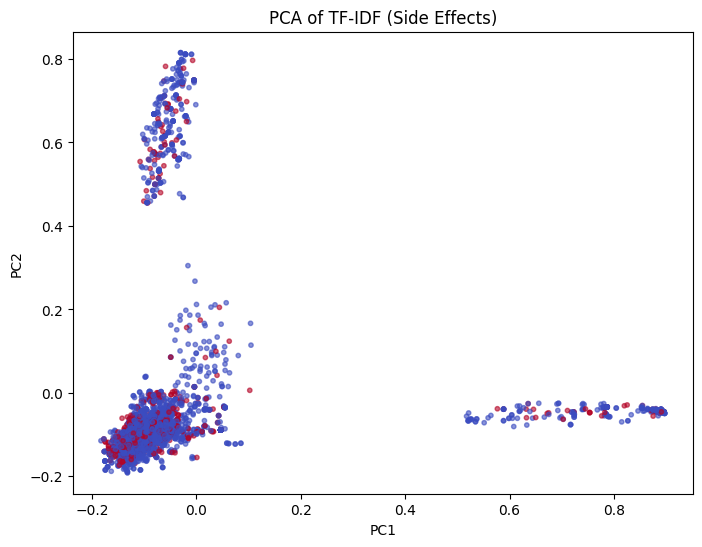

In [10]:
from sklearn.decomposition import PCA

tfidf_full = tfidf.transform(data['side_effects'].fillna(''))
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(tfidf_full.toarray())
plt.figure(figsize=(8,6))
plt.scatter(pcs[:,0], pcs[:,1], c=data['high_rating'], cmap='coolwarm', alpha=0.6, s=10)
plt.title('PCA of TF-IDF (Side Effects)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()


🔍 Generating SHAP explanations (this may take a minute)...


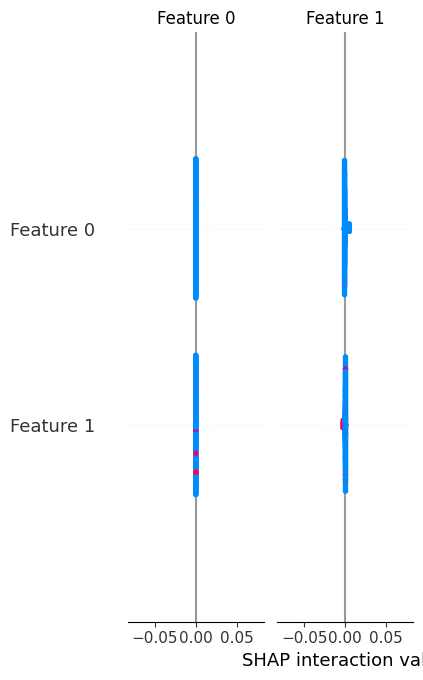

In [11]:
import shap

print("\n🔍 Generating SHAP explanations (this may take a minute)...")
pre = pipeline.named_steps['preprocessor']
X_train_trans = pre.transform(X_train[:200])
model_to_explain = pipeline.named_steps['clf']
explainer = shap.Explainer(model_to_explain, X_train_trans)
shap_values = explainer(pre.transform(X_test[:200]))

shap.summary_plot(shap_values, pre.transform(X_test[:200]), plot_type='bar')
plt.show()

In [12]:
import joblib
joblib.dump(pipeline, "rf_pipeline_drugs.joblib")
print("💾 Saved model as rf_pipeline_drugs.joblib")

💾 Saved model as rf_pipeline_drugs.joblib
